## Setup and Configuration

In [1]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time 
import importlib

import utils
import image_render_code as imgutils
import dataloader_utils as dui
import pytorch_gradcam
import train_utils
import networks

from matplotlib.colors import LinearSegmentedColormap

# Paths and Experiment Configuration
train_path = '../data/cutting_datasets/train'
test_path = '../data/cutting_datasets/test'
'''
To run the generalization version of the experiments (with missing object types in the training set), use
train_path = '../data/cutting_datasets/generalization_train'
test_path = '../data/cutting_datasets/generalization_test'
'''
trained_model_name = 'EventNetC2' # Name of the trained model to be evaluated

# Define input characteristics, and what time horizon the prediction is made for
# These values are from the original experiment
horizon = 3 
block_size = 10 # Corresponds to length M
batch_size = 32
cnnColorMap="seismic" # Colormap to be used for input rendering

#How to handle images
saveIndivImgs = False # Set to True to save the individual frame insepaction images instead of viewing them
saveFeatEvalImgs = True # Set to false to only display the feature evaluation images without saving them
indivImgSavePath = '../GradCamFigs/' # Where to save the individual visually interpretable images
featEvalSavePath = '../FeatureEvaluationFigs/' # Where to save the feature evaluation images


## Load Data

In [2]:
# Initialize dataloaders
train_dl = dui.EventDataloader(train_path, dataType="train", block_size = block_size, scale_pixels=1, multi_class = False, block_horizon=horizon, colormap=cnnColorMap)
train_loader = torch.utils.data.DataLoader(train_dl, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

# Pass the training data scaler params to the testing loader
scaler = train_dl.dh.scaler
gradcam_scaler_params = train_dl.dh.gradcam_scaler_params
test_dl = dui.EventDataloader(test_path, dataType="visual", block_size = block_size, scaler = scaler, gradcam_scaler_params = gradcam_scaler_params, scale_pixels=1, multi_class = False, block_horizon=horizon, colormap=cnnColorMap)
gc_test_loader = torch.utils.data.DataLoader(test_dl, batch_size=1, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)


Retrieved 34 position files, 34 force files and 34 input files from base directory '../data/cutting_datasets/train' 
0 files need to be fixed
Retrieved 10 position files, 10 force files and 10 input files from base directory '../data/cutting_datasets/test' 
0 files need to be fixed


## Load trained model

In [3]:
if(torch.cuda.is_available()):
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

# Model definition must be same as saved model
model = networks.MultiEventNetTemplate(classes = 2, inputImgSize=[9,10], channels_in=3,channels=[32,64,128], filterSizes=[(1,5),(1,3),(1,1)],\
                                       strides=[(1,1),(1,1),(1,1)], paddings=[(0,0//2),(0,0//2),(0,0)],biases=True).to(device).float()
model_name = trained_model_name
trainer_chkp = train_utils.TrainUtils(model, None, None, None, None, None)
trainer_chkp.loadModel(model_name)
model = trainer_chkp.model

## Individual Gradcam Inspection Version

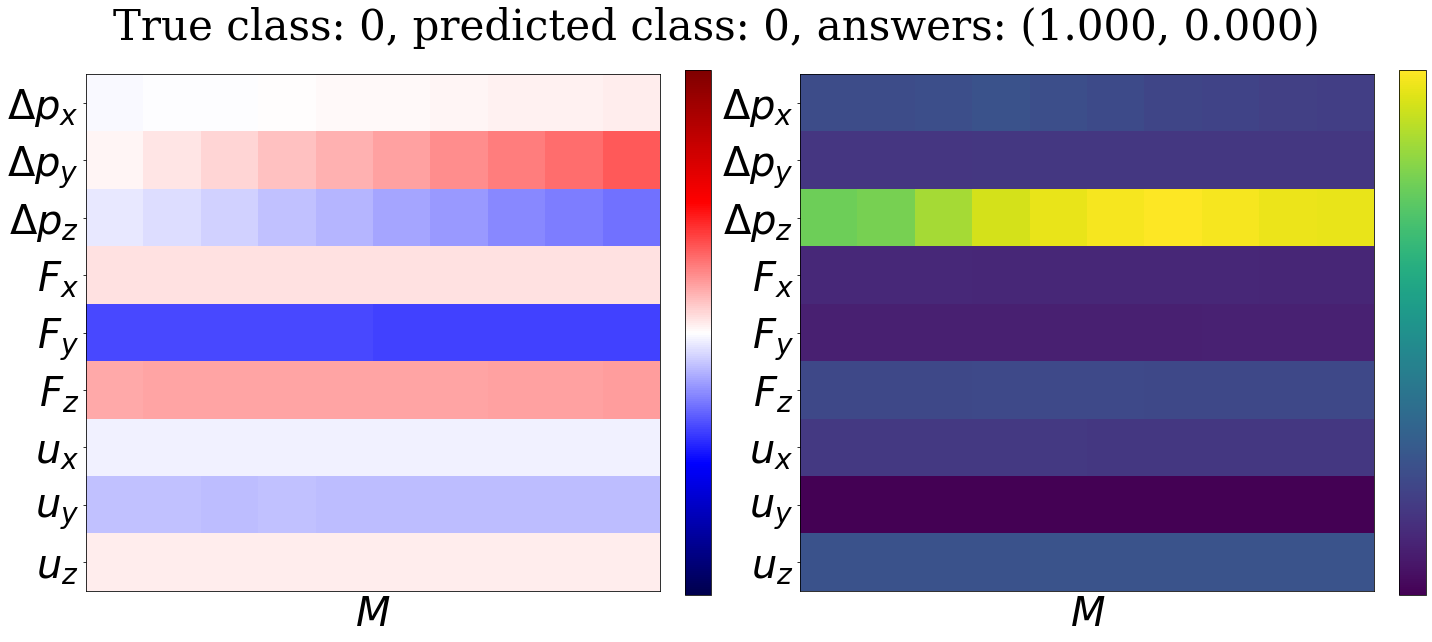

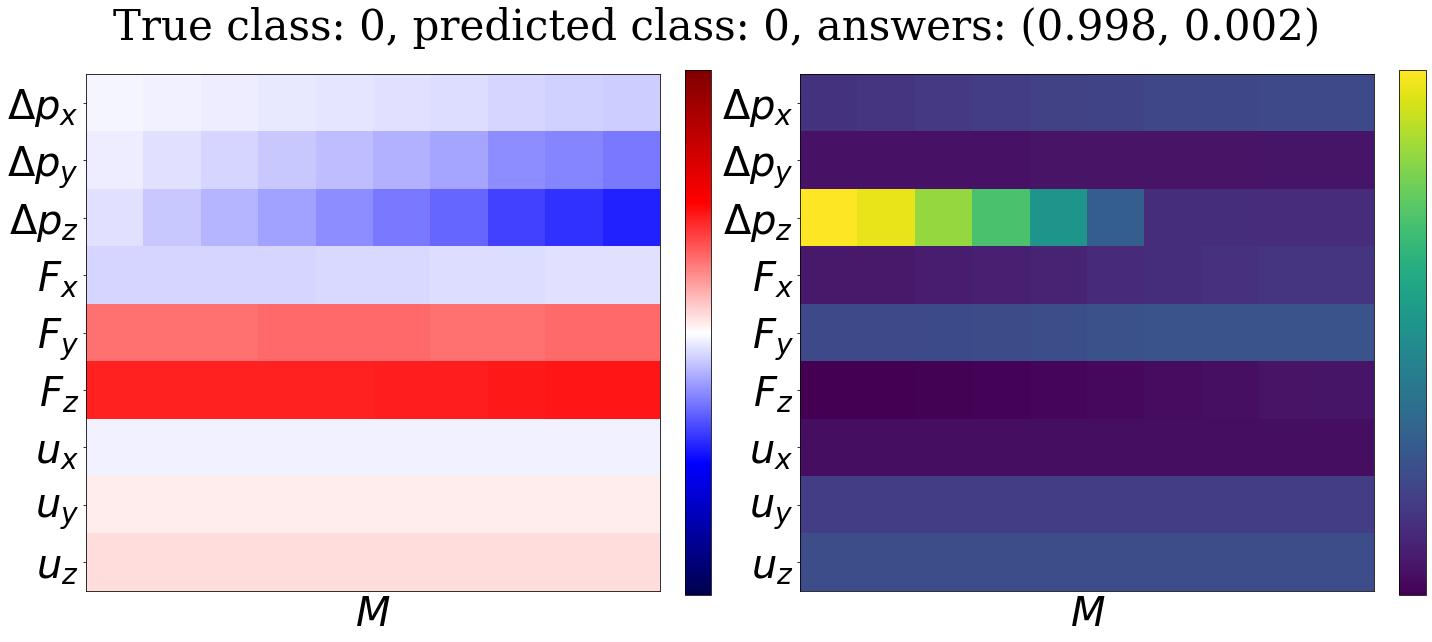

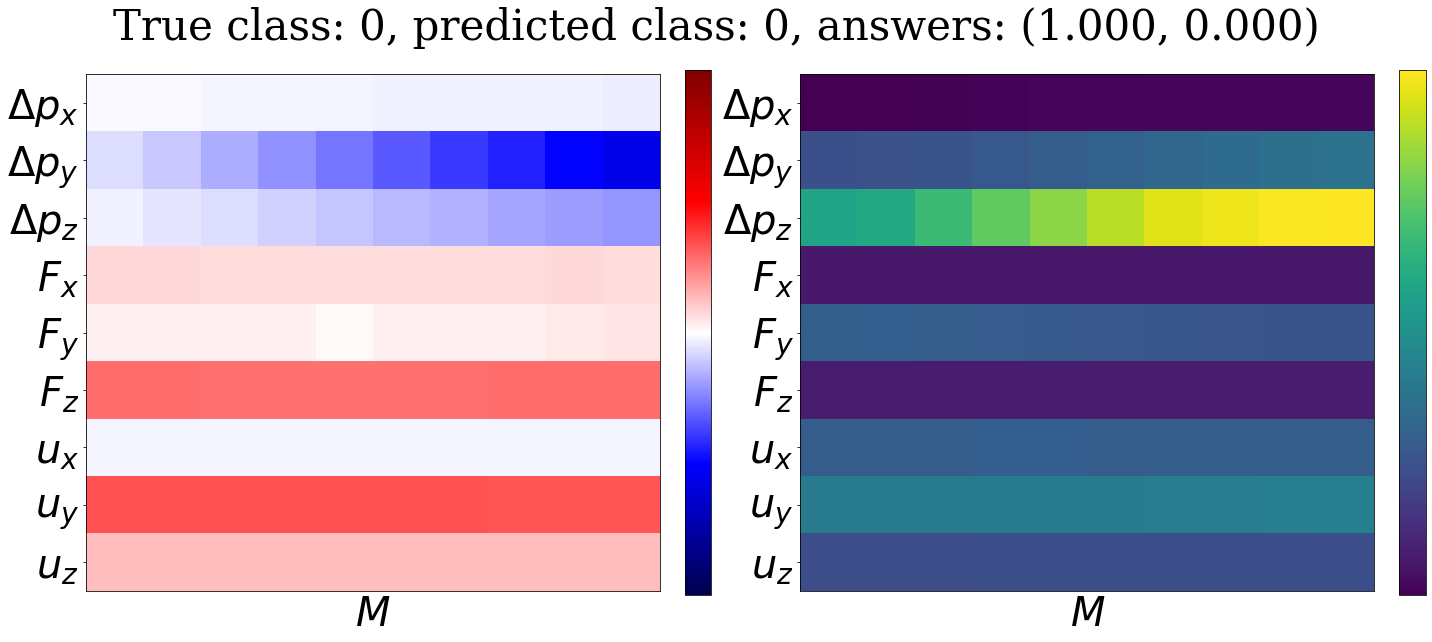

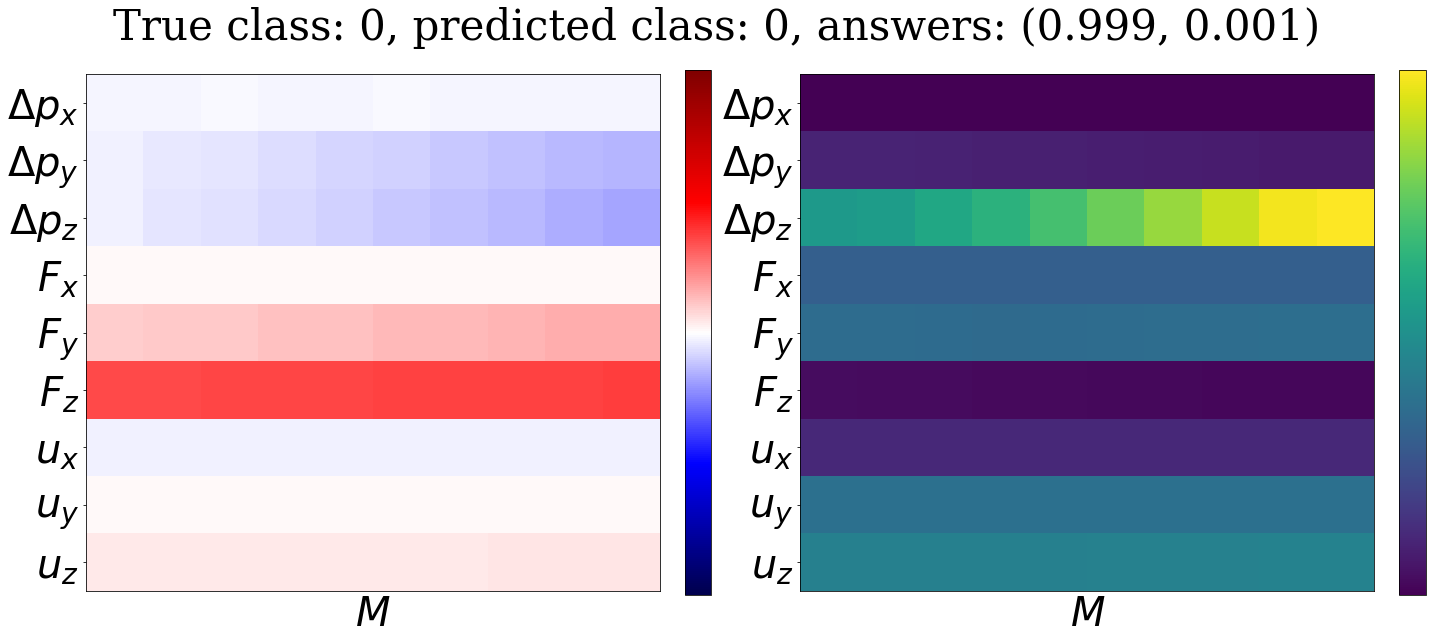

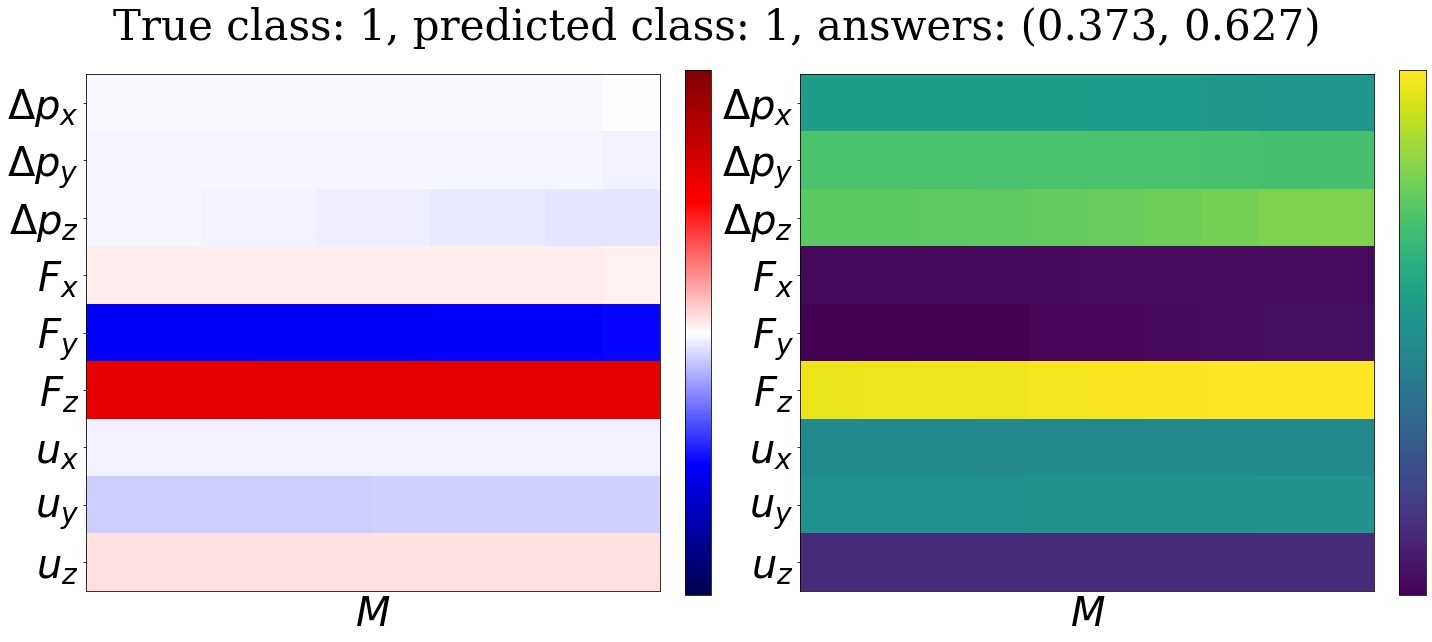

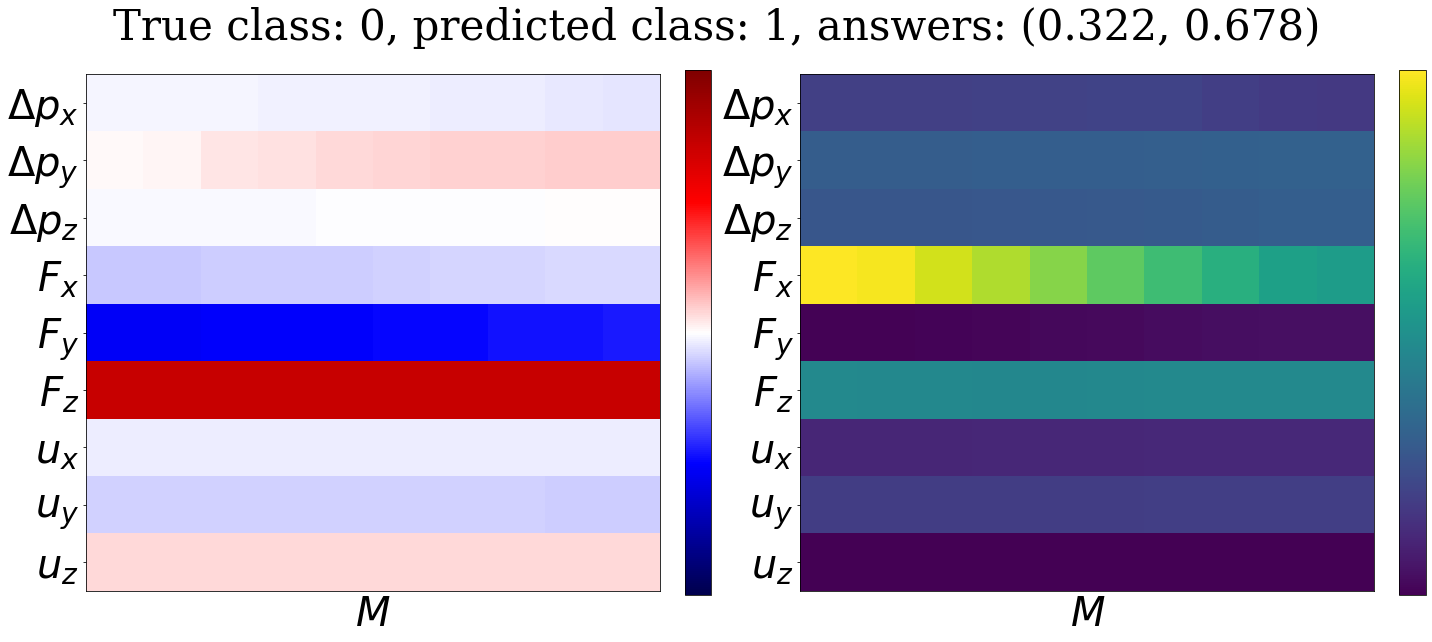

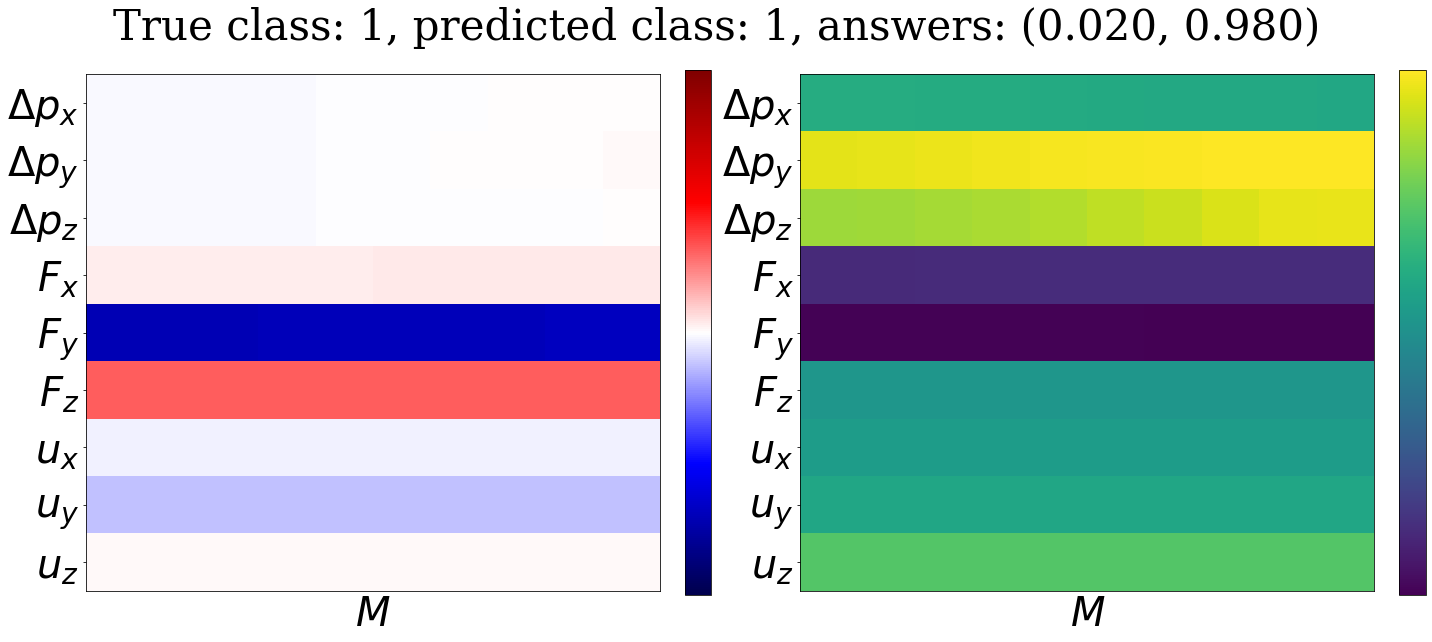

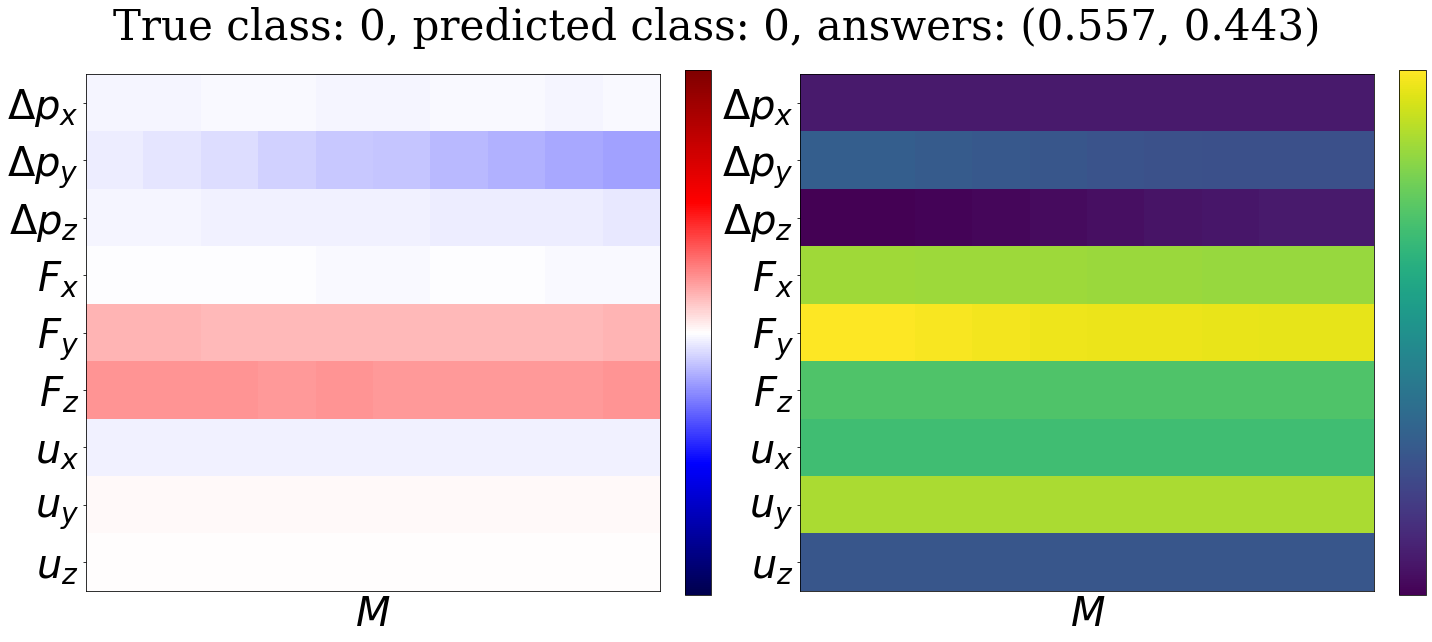

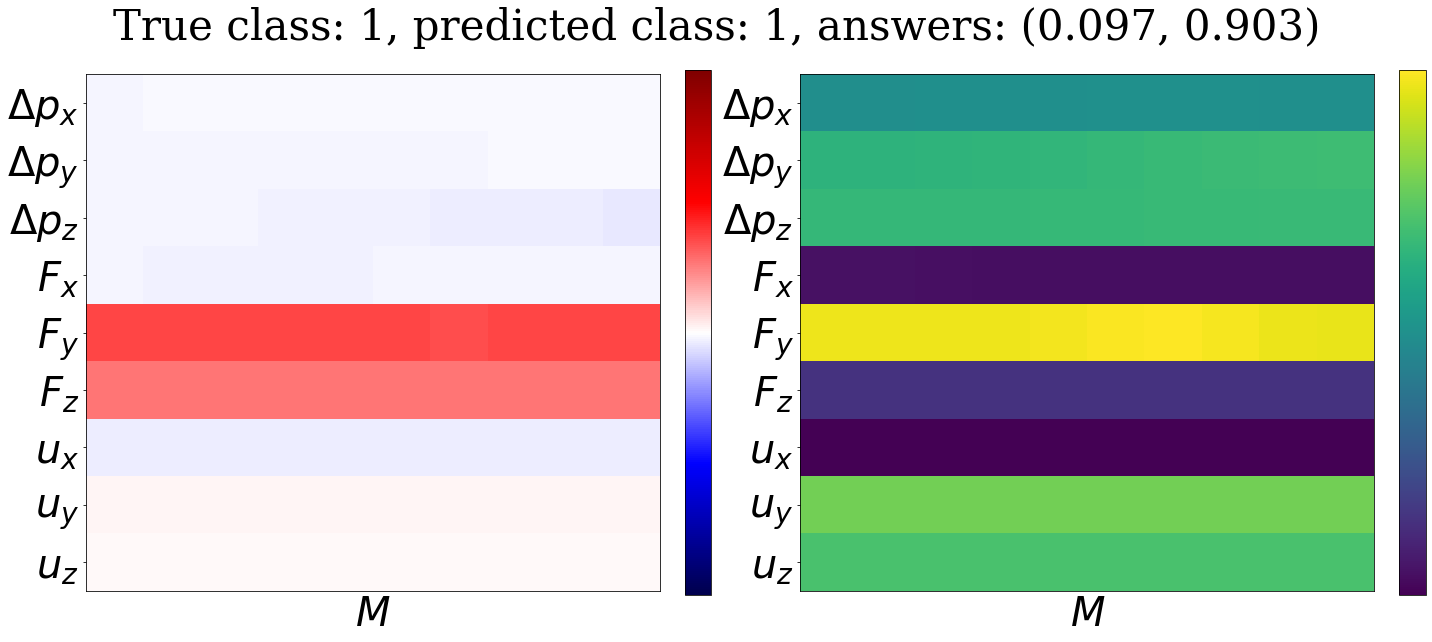

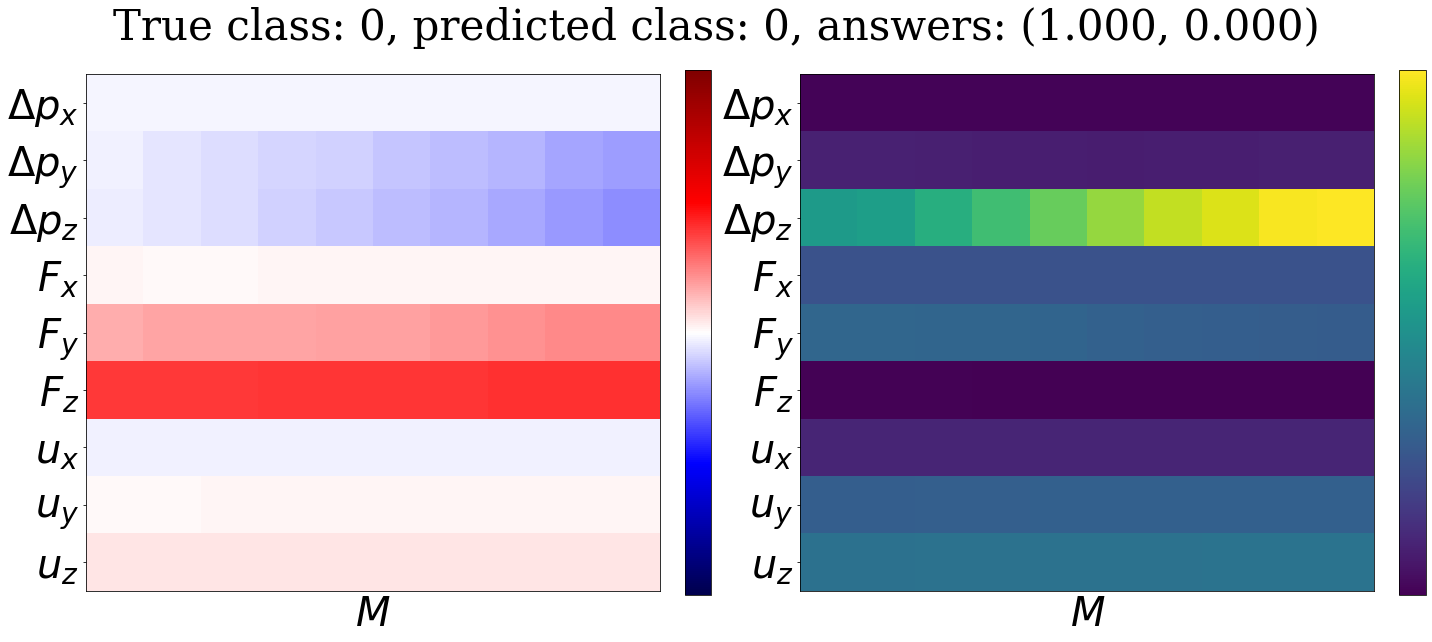

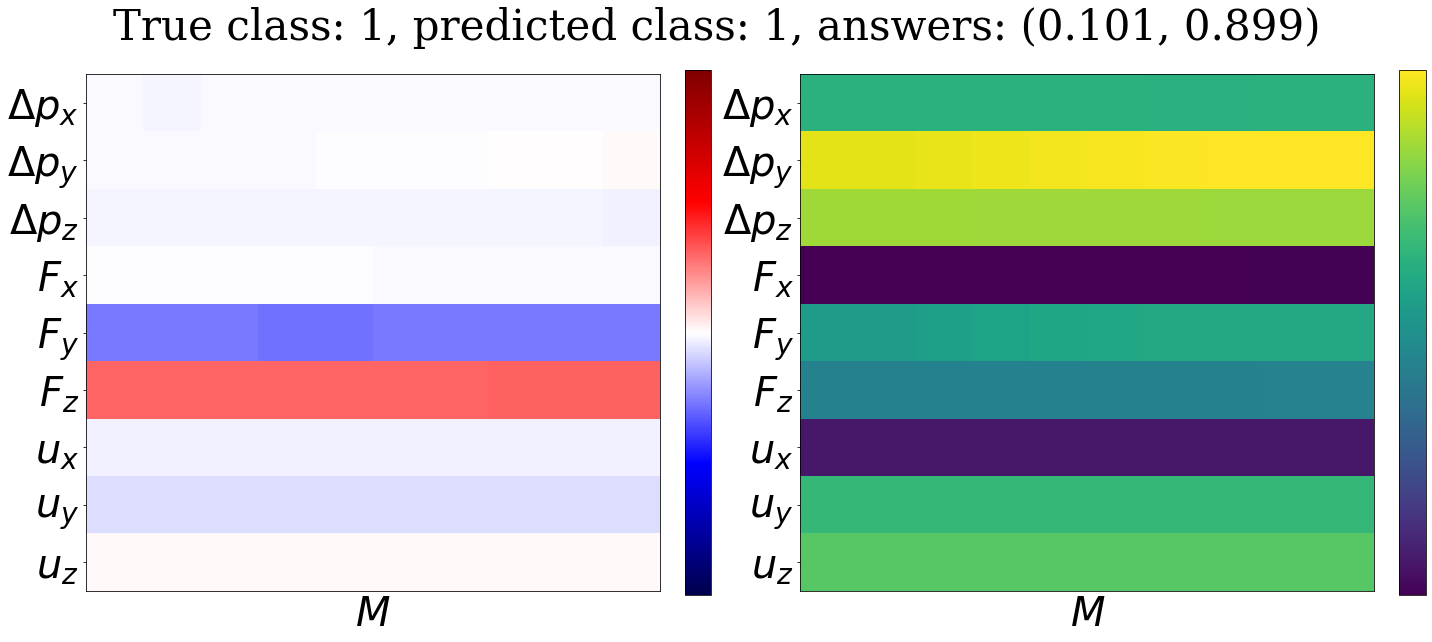

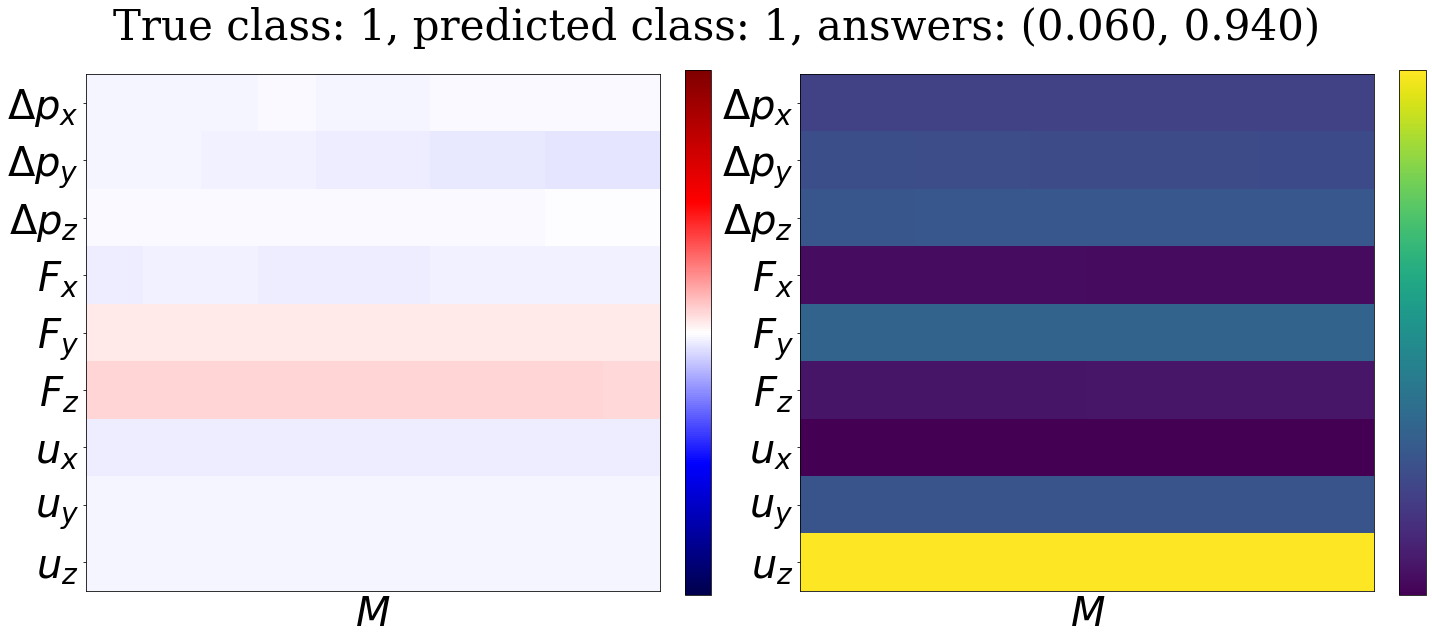

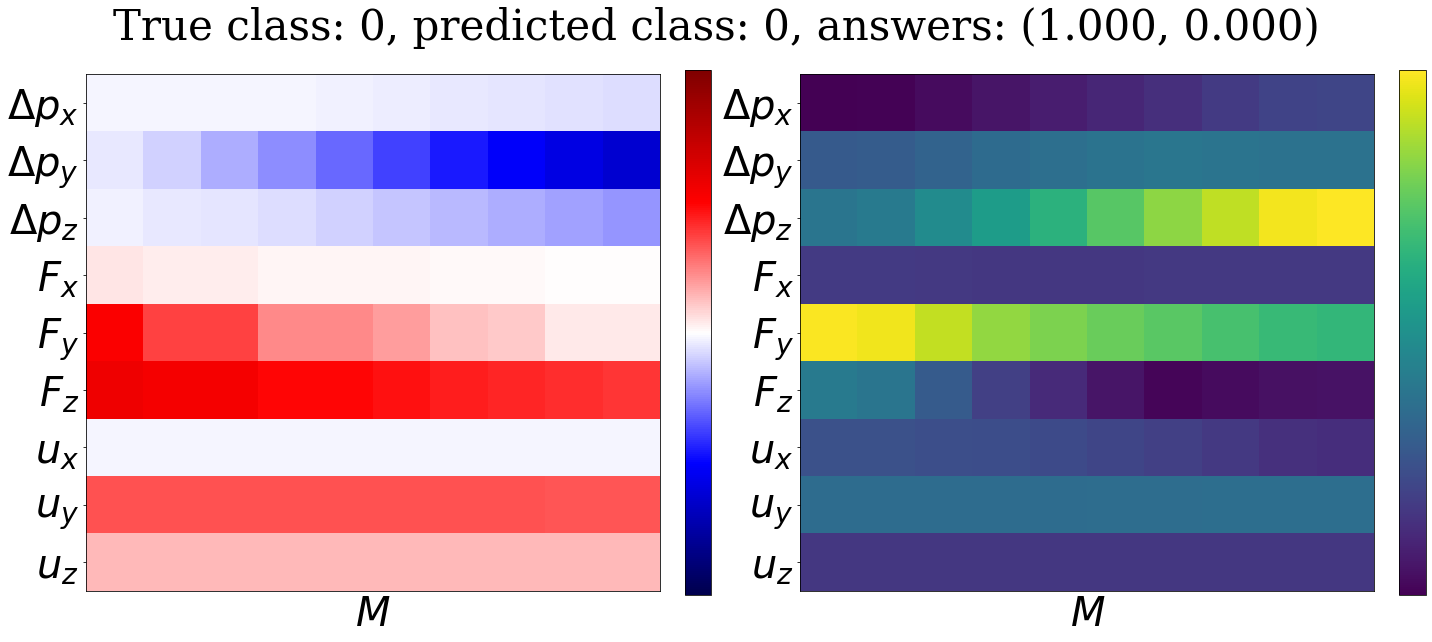

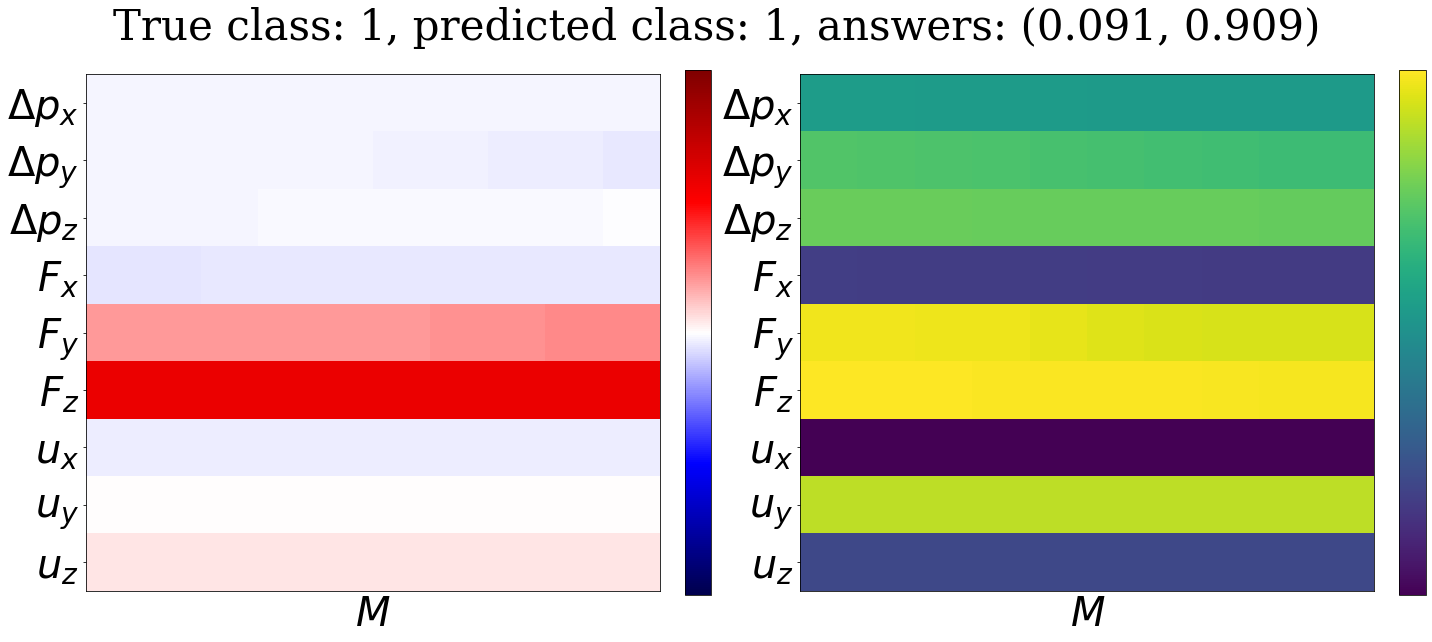

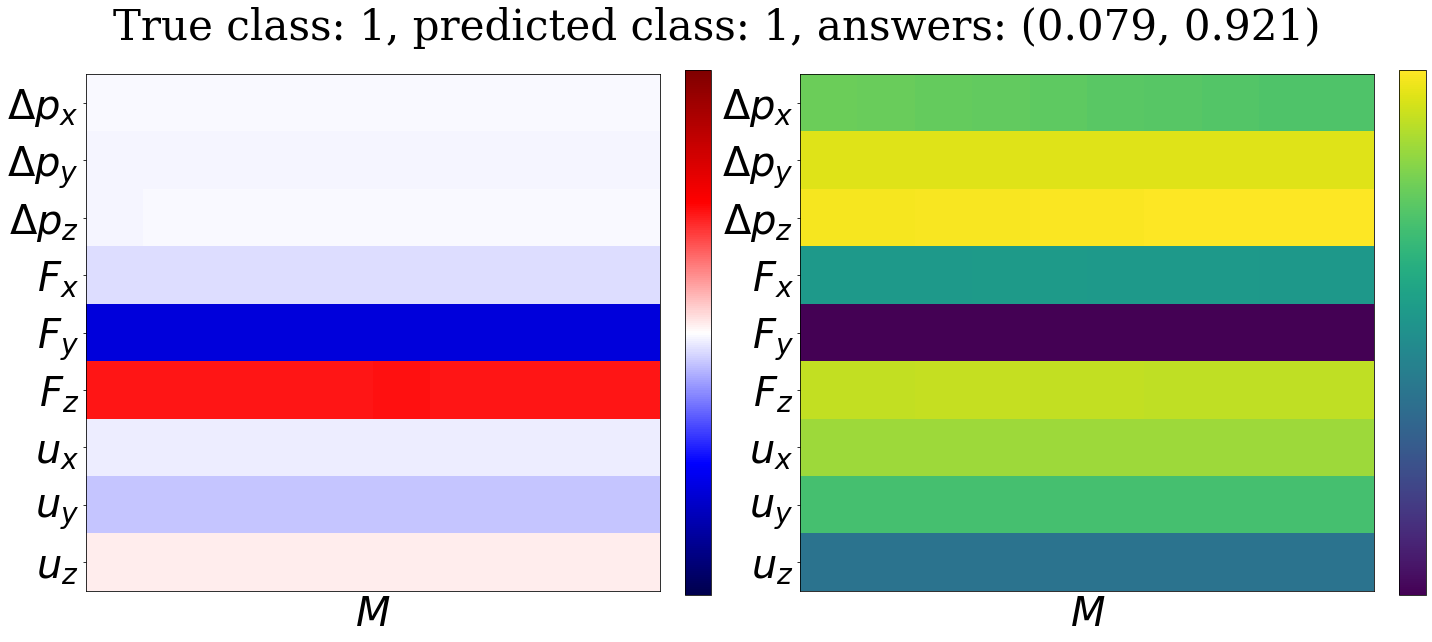

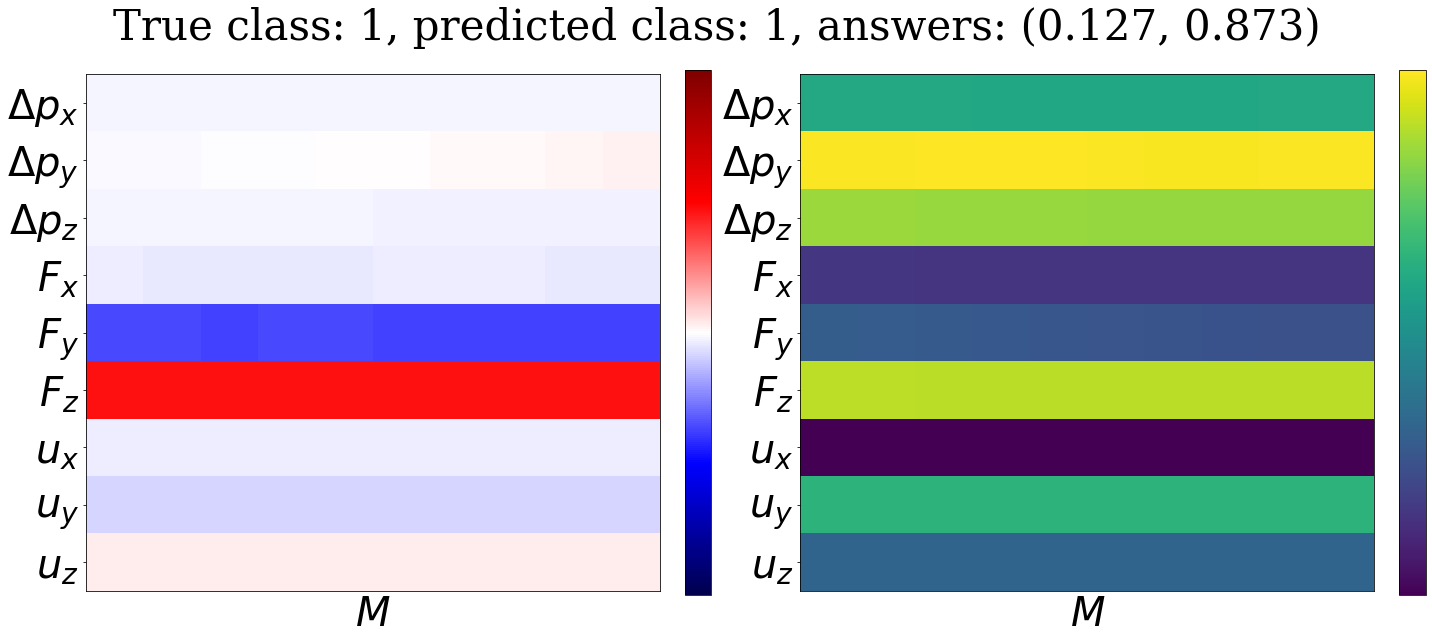

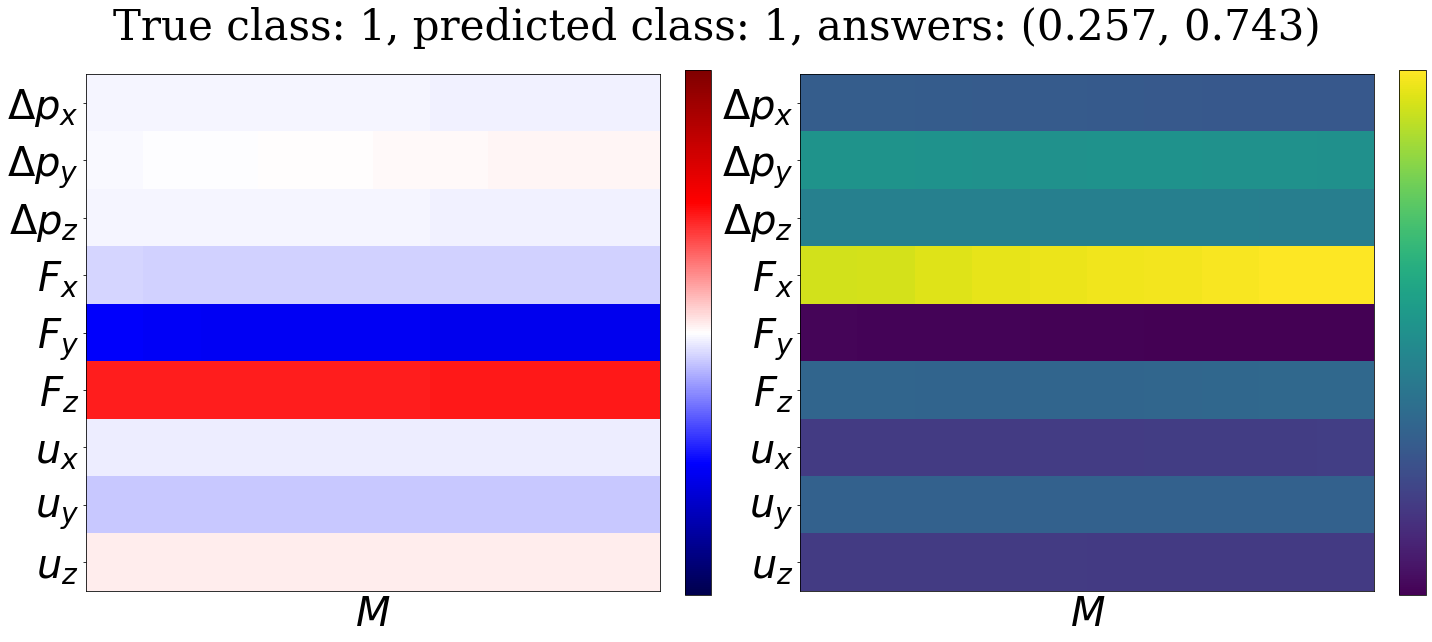

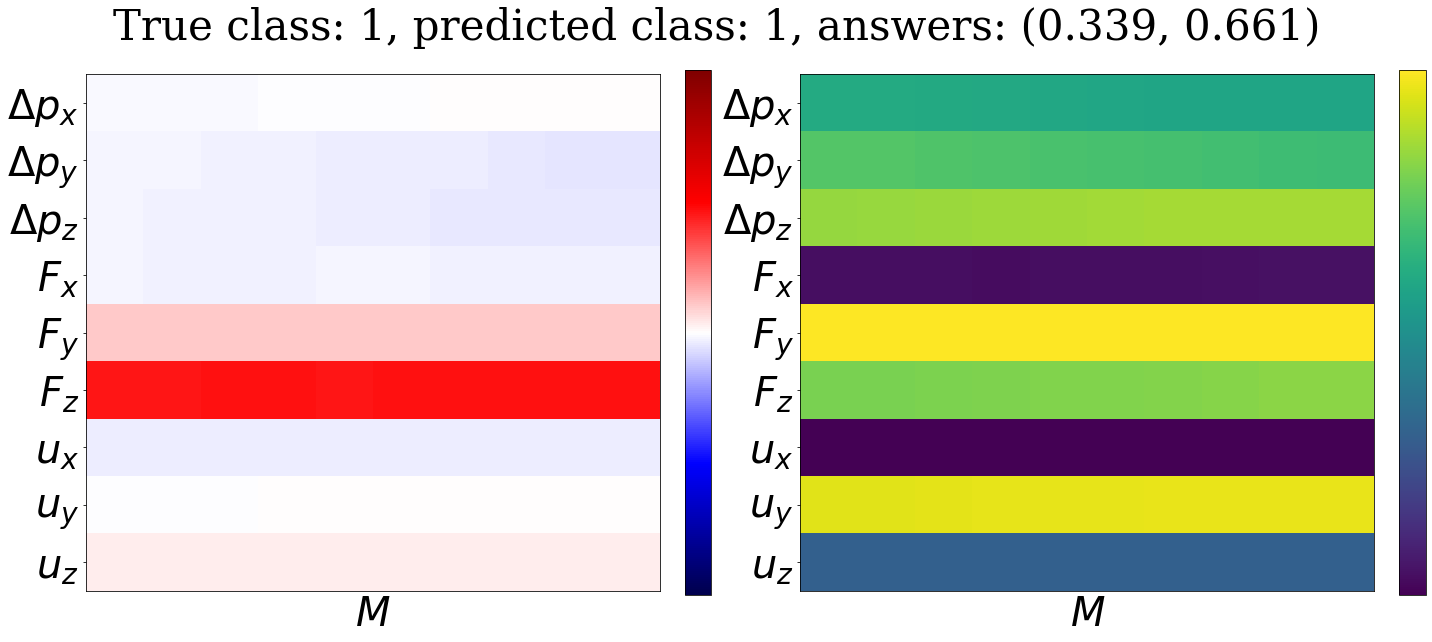

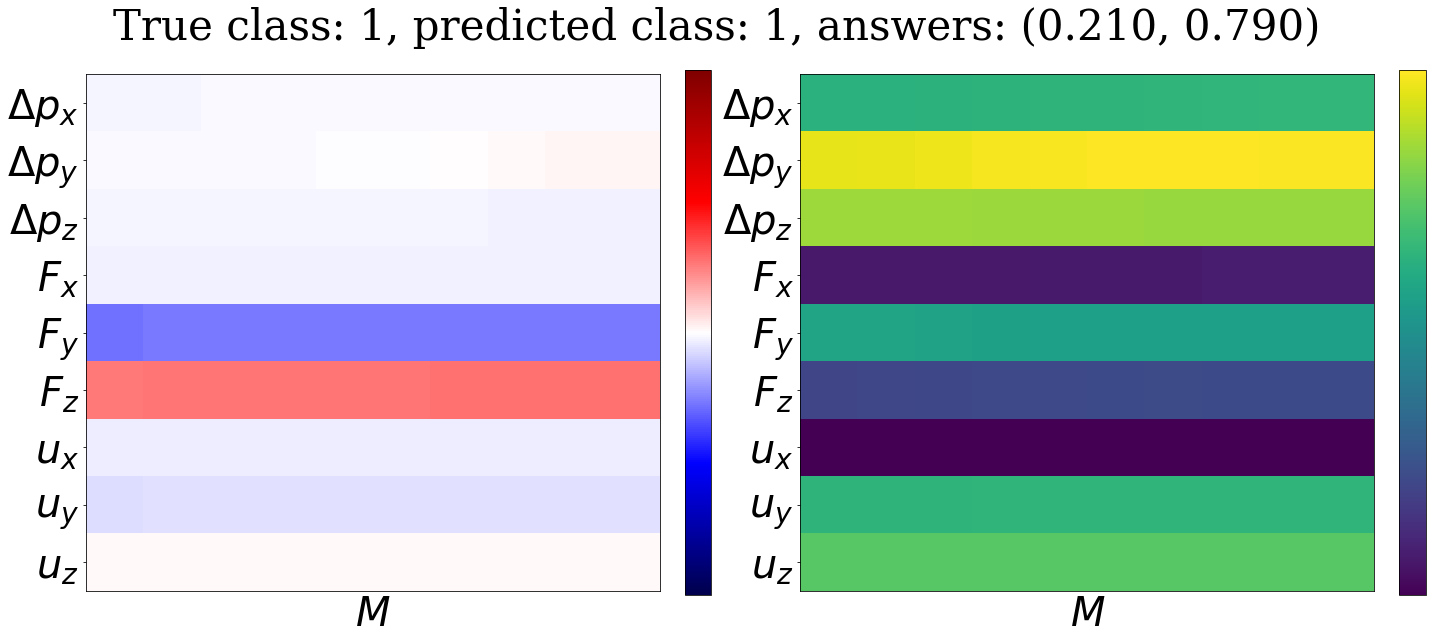

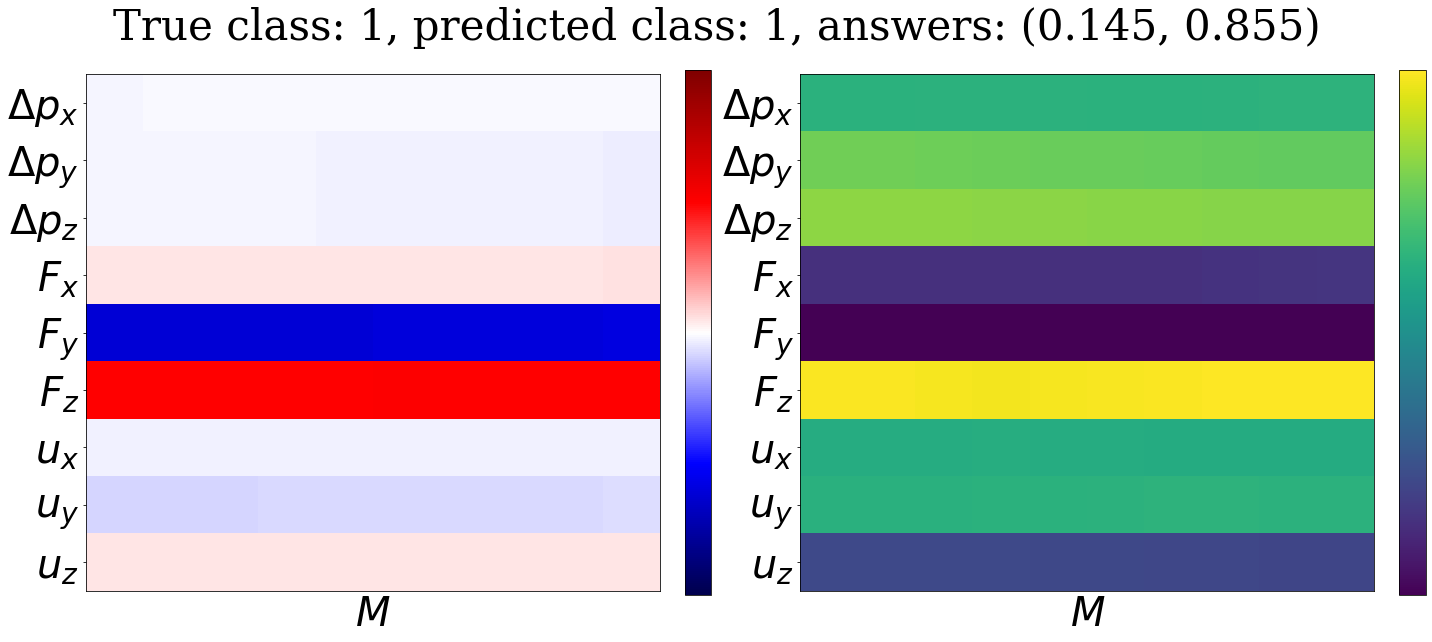

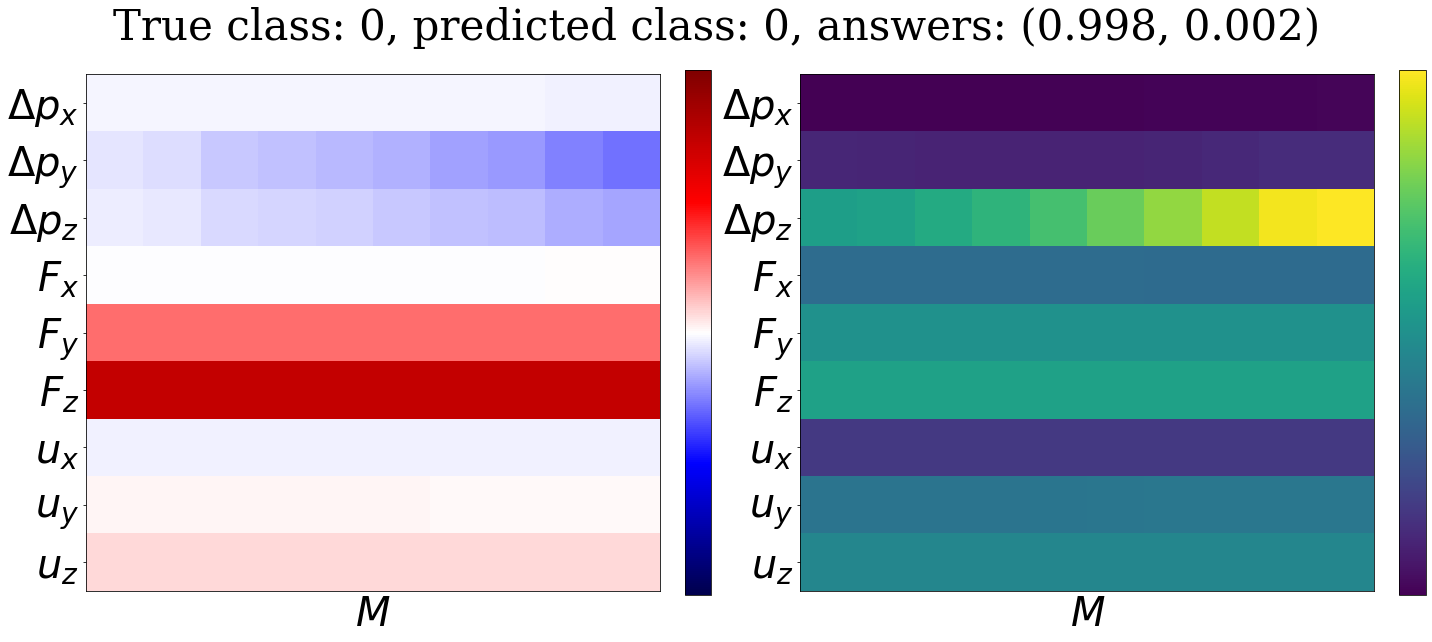

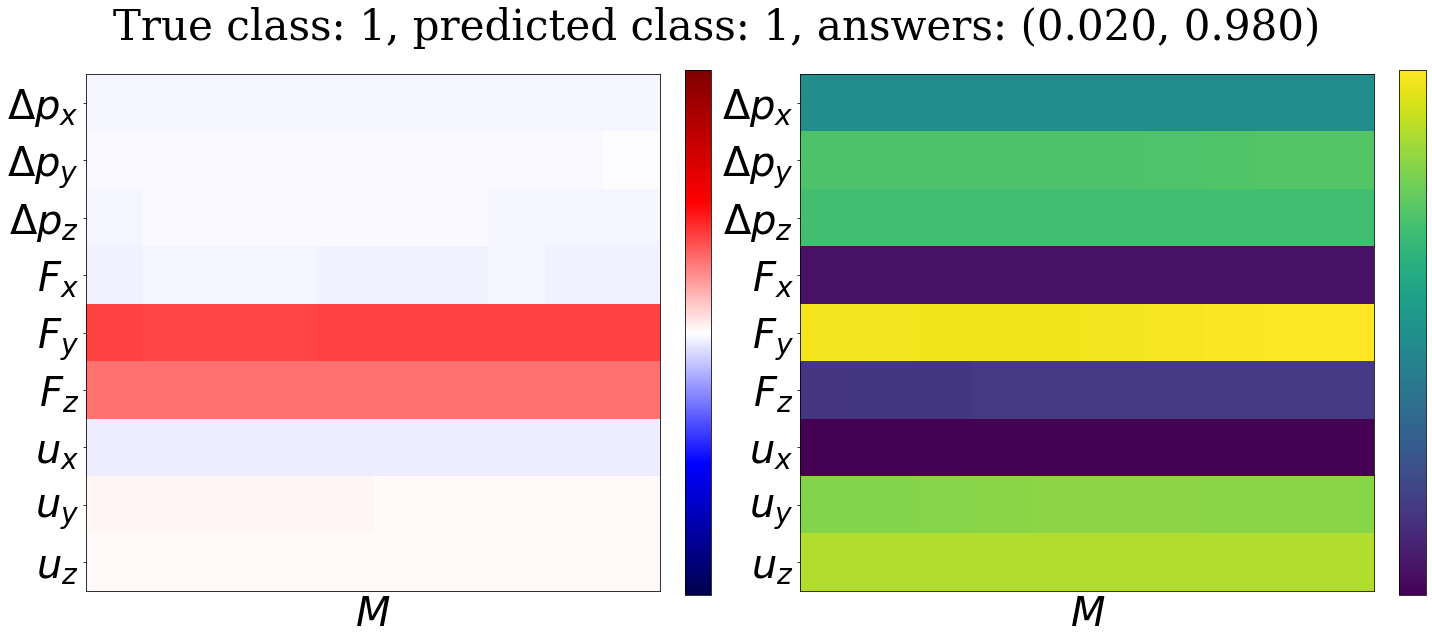

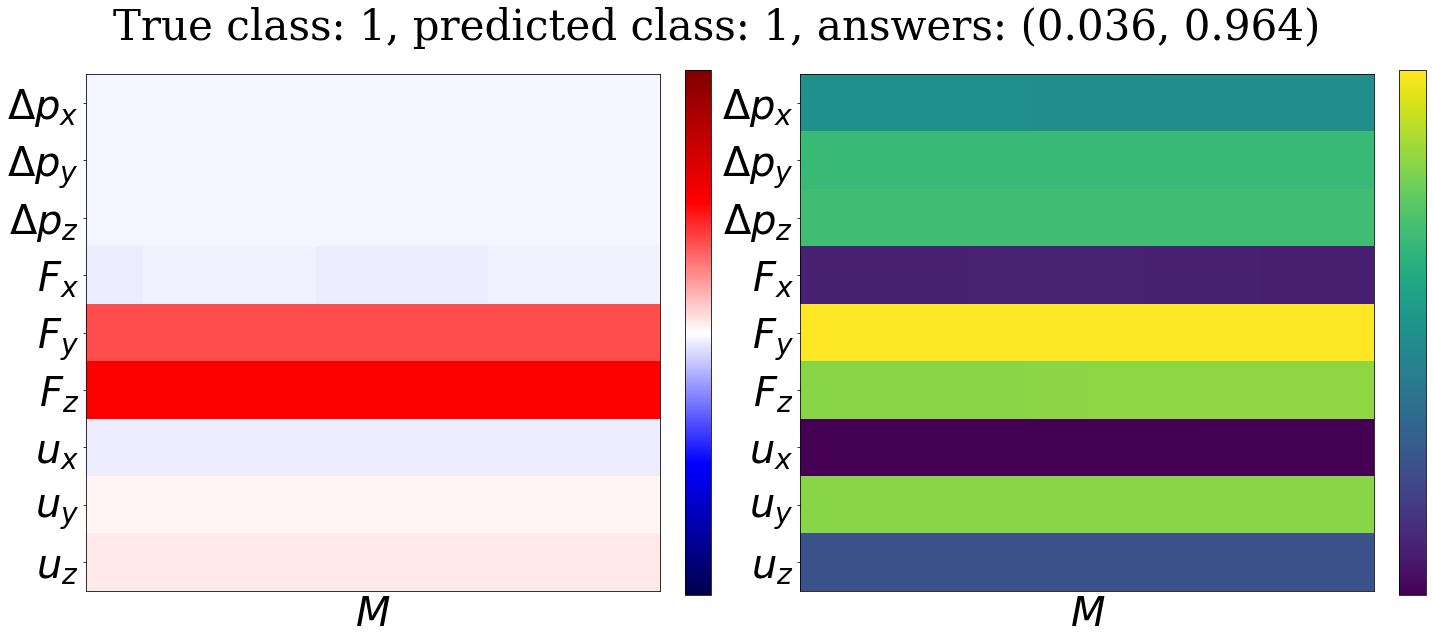

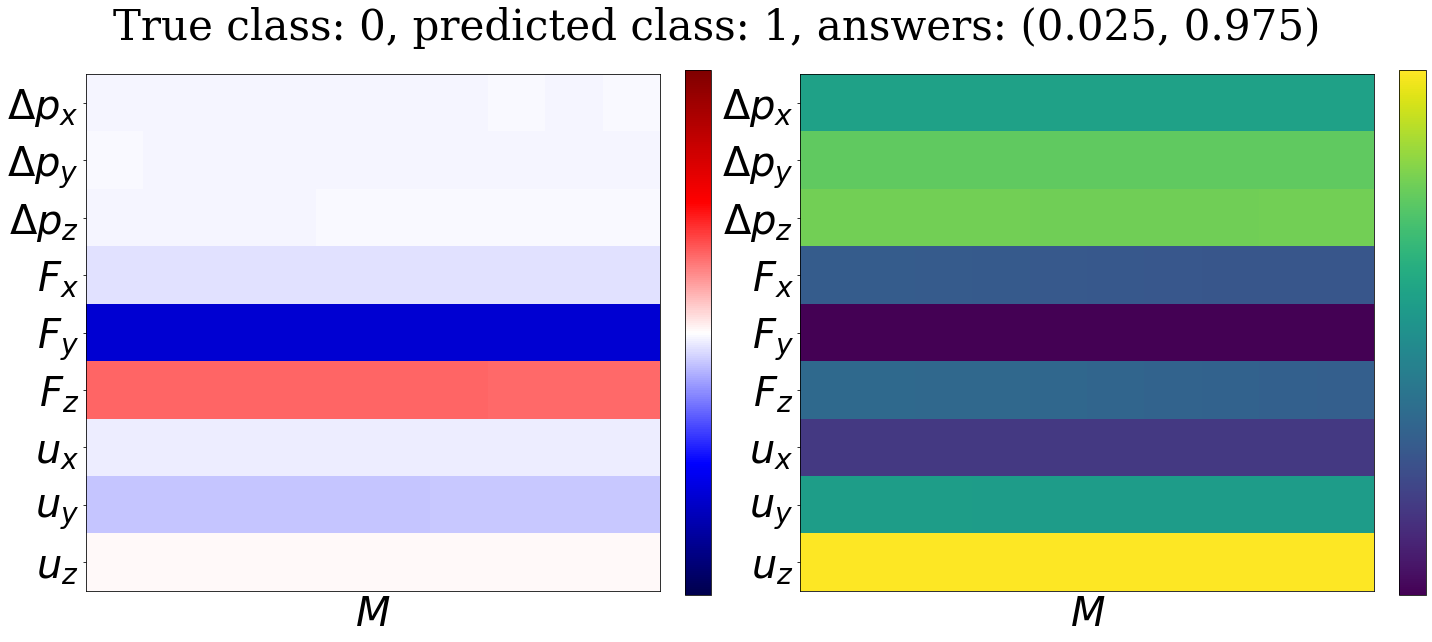

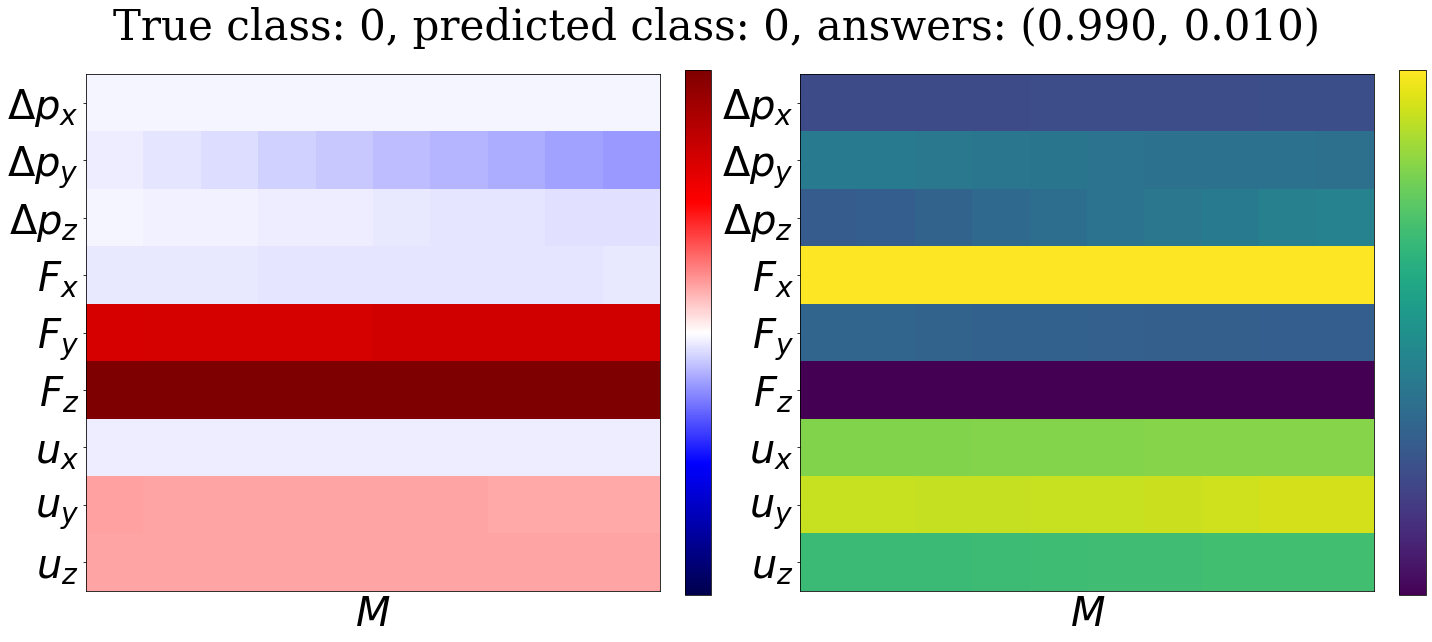

In [4]:
importlib.reload(pytorch_gradcam)

plot_labels = ["$\Delta p_x$", "$\Delta p_y$", "$\Delta p_z$", "$F_x$", "$F_y$", "$F_z$", "$u_x$", "$u_y$", "$u_z$" ]

# Gradcam image upscaling factor (if desired)
cellSize = [10,10]
model = model.to(device)

# Create a gradCam instance with hooks to correct layers
gradcamObj = pytorch_gradcam.GradCam(model, target_layer_names = "conv3",\
                                   use_cuda = False if device == torch.device("cpu") else True,\
                                   archType = "normal")

model = model.float()
model.eval()

for i, data in enumerate(gc_test_loader):
    # Get the inputs; data is a list of [inputs, labels]
    inputs, labels = data[0]
    inputs = inputs.to(device)
    labels = labels.to(device)
    cam = gradcamObj(inputs.float())    

    origImage = data[1][0]
    multicolor_img = np.moveaxis(origImage.cpu().numpy(),0,-1)
    multicolor_img = multicolor_img.squeeze()
    combined = pytorch_gradcam.show_cam_on_image(multicolor_img, cam)

    # Increase to area size along time axis
    imgOut = np.repeat(combined, cellSize[0],axis=1)
    # Increase to area size along feature axis
    imgOut = np.repeat(imgOut, cellSize[1],axis=0)
    netOut = model(inputs.float())[0]

    cam_complement = gradcamObj(inputs.float(), torch.argmin(netOut).item())

    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,20), sharex= False, sharey=False)
    fig.suptitle('True class: %d, predicted class: %d, answers: (%.3f, %.3f)' %(labels[0],torch.argmax(netOut), netOut[0], netOut[1]), fontname = 'serif', fontsize = 42)

    im1 = ax1.imshow(multicolor_img, cmap = 'seismic')
    cb1 = fig.colorbar(im1, ax = ax1, fraction = 0.042, pad=0.04)
    cb1.set_ticks([])   
    ax1.set_yticks(np.arange(len(multicolor_img)))
    ax1.set_yticklabels(plot_labels, fontsize = 40)
    ax1.set_xticks([])
    ax1.set_xlabel("$M$", fontsize = 40)

    im2 = ax2.imshow(cam)
    cb2 = fig.colorbar(im2, ax = ax2, fraction = 0.042, pad = 0.04)
    cb2.set_ticks([])
    ax2.set_yticks(np.arange(len(cam)))
    ax2.set_yticklabels(plot_labels, fontsize = 40)   
    ax2.set_xticks([])
    ax2.set_xlabel("$M$", fontsize = 40)


    fig.tight_layout()
    fig.subplots_adjust(top=1.5)

    if(saveIndivImgs):
        path = indivImgSavePath
        path = path + model_name + '/'

        if not os.path.exists(path):
            os.makedirs(path)

        fna = str(i) +'.pdf'
        name = path + fna
        name2 = path + str(i) + '.png'
        plt.savefig(name, bbox_inches = 'tight', pad_inches = 0)
        plt.savefig(name2, bbox_inches = 'tight')
    else:
        plt.show()
        # Only show max 25 example images if displaying instead of saving
        if(i+1==25):
            break

    plt.close()
        

## GradCam Intensity Version

In [5]:
plot_labels = ["$\Delta p_x$", "$\Delta p_y$", "$\Delta p_z$", "$F_x$", "$F_y$", "$F_z$", "$u_x$", "$u_y$", "$u_z$" ]

# Gradcam image upscaling factor (if desired)
cellSize = [10,10]

model = model.to(device)

# Create a gradCam instance with hooks to correct layers
gradcamObj = pytorch_gradcam.GradCam(model, target_layer_names = "conv3",\
                                   use_cuda = False if device == torch.device("cpu") else True,\
                                   archType = "normal")

model = model.float()
model.eval()

# Instantiate feature evaluator for compiling intensity results
featureEvaluator = pytorch_gradcam.FeatureEvaluator(featureThreshold=0.7)

for i, data in enumerate(gc_test_loader):
        # get the inputs; data is a list of [inputs, labels]
        if((i+1)%250==0):
            print("evaluated ",i,"/",len(gc_test_loader))
          
        inputs, labels = data[0]
        inputs = inputs.to(device)
        labels = labels.to(device)
        cam = gradcamObj(inputs.float())    
        
        origImage = data[1][0]

        multicolor_img = np.moveaxis(origImage.cpu().numpy(),0,-1)

        multicolor_img = multicolor_img.squeeze()
        combined = pytorch_gradcam.show_cam_on_image(multicolor_img, cam)
        
        #increase to area size along time axis
        imgOut = np.repeat(combined, cellSize[0],axis=1)
        #increase to area size along feature axis
        imgOut = np.repeat(imgOut, cellSize[1],axis=0)
        
        netOut = model(inputs.float())[0]
        featureEvaluator.update(torch.argmax(netOut),labels[0],cam)

print("-------------------")
featureEvaluator.showResults()

evaluated  249 / 2826
evaluated  499 / 2826
evaluated  749 / 2826
evaluated  999 / 2826
evaluated  1249 / 2826
evaluated  1499 / 2826
evaluated  1749 / 2826
evaluated  1999 / 2826
evaluated  2249 / 2826
evaluated  2499 / 2826
evaluated  2749 / 2826
-------------------
out of 1145 TP cases, features above 0.700000 were: 
P_x:  18
P_y:  107
P_z:  609
F_x:  534
F_y:  441
F_z:  350
U_x:  310
U_y:  334
U_z:  391
-----------------
out of 1253 TN cases, features above 0.700000 were: 
P_x:  66
P_y:  706
P_z:  723
F_x:  32
F_y:  301
F_z:  447
U_x:  36
U_y:  340
U_z:  592
-----------------
out of 127 FP cases, features above 0.700000 were: 
P_x:  1
P_y:  22
P_z:  17
F_x:  89
F_y:  69
F_z:  57
U_x:  48
U_y:  27
U_z:  86
-----------------
out of 301 FN cases, features above 0.700000 were: 
P_x:  23
P_y:  155
P_z:  203
F_x:  7
F_y:  93
F_z:  98
U_x:  5
U_y:  97
U_z:  139
-----------------
____________________________________________
out of 1145 TP cases, the most cared about feature was: 
P_x:  2
P

### Display Histograms

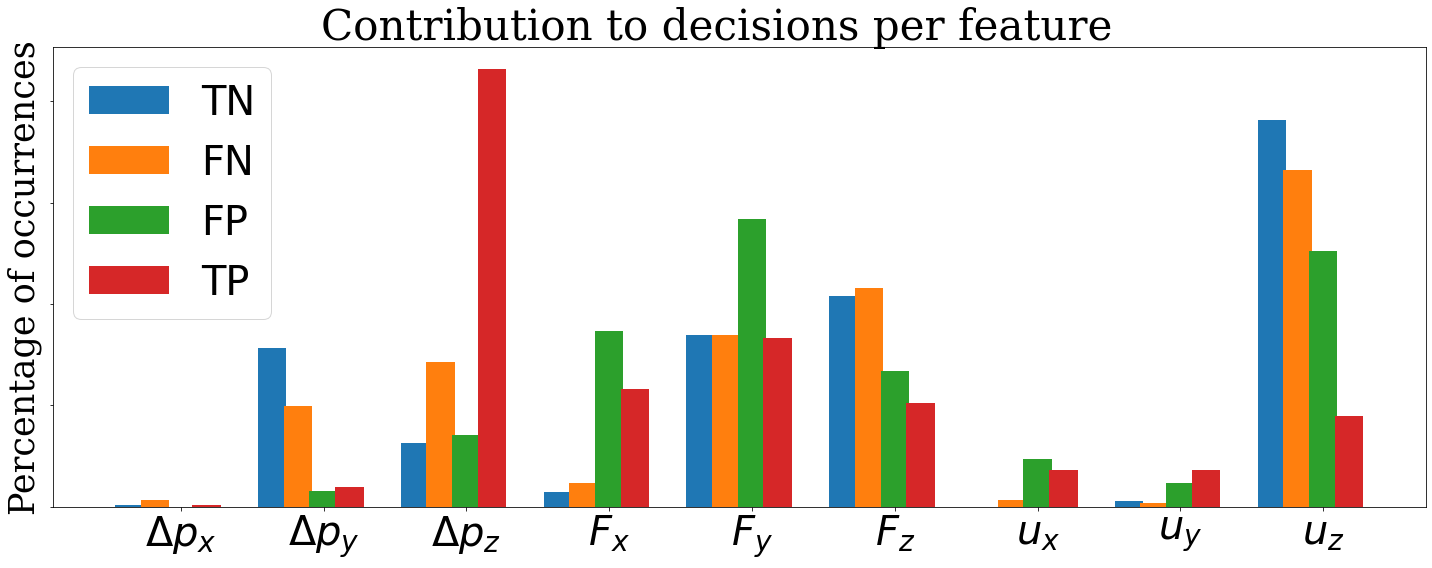

In [6]:
plot_labels = ["$\Delta p_x$", "$\Delta p_y$", "$\Delta p_z$", "$F_x$", "$F_y$", "$F_z$", "$u_x$", "$u_y$", "$u_z$" ]
FP = np.array(featureEvaluator.featureCountsMax['FP'])/featureEvaluator.caseCounts['FP']
TP = np.array(featureEvaluator.featureCountsMax['TP'])/featureEvaluator.caseCounts['TP']
FN = np.array(featureEvaluator.featureCountsMax['FN'])/featureEvaluator.caseCounts['FN']
TN = np.array(featureEvaluator.featureCountsMax['TN'])/featureEvaluator.caseCounts['TN']

ind = np.arange(len(FP))  # the x locations for the groups
width = 0.2# the width of the bars

fig, ax = plt.subplots(figsize = (20, 8))
fig.suptitle('Contribution to decisions per feature', fontname = 'serif', fontsize = 42)

offset = 0.36
rects1 = ax.bar(ind-offset, TN, width,
                label='TN')
rects2 = ax.bar(ind - offset/2, FN, width, 
                label='FN')
rects3 = ax.bar(ind , FP, width,
                label='FP') 
rects4 = ax.bar(ind + offset/2, TP, width,
                label='TP')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of occurrences', fontname = 'serif', fontsize = 35)
ax.set_xticks(ind)
ax.set_xticklabels(plot_labels, fontsize = 40)
ax.legend(fontsize = 40)
ax.set_yticklabels(labels = [], fontsize = 40)

fig.tight_layout()
fig.subplots_adjust(top=0.91)

if(saveFeatEvalImgs):
    path = featEvalSavePath
    if not os.path.exists(path):
        os.makedirs(path)
    fna = model_name +'_per-feat.pdf'
    name = path + fna
    name2 = path + model_name +'_per-feat.png'
    plt.savefig(name, bbox_inches = 'tight', pad_inches = 0)
    plt.savefig(name2, bbox_inches = 'tight')
plt.show()
plt.close()

